In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import logging
from numpy import random
#import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

%matplotlib inline



In [3]:
data = pd.read_csv("data.csv") 

In [4]:
data.dropna(inplace=True)
data.isnull().sum()
data.shape

(39991, 3)

In [6]:
print (data['Label'].value_counts())

bangladesh            12239
opinion               10611
economy                4771
sports                 3349
entertainment          2447
technology             2113
international          1835
life-style             1121
education               774
art-and-literature      366
northamerica            189
durporobash             176
Name: Label, dtype: int64


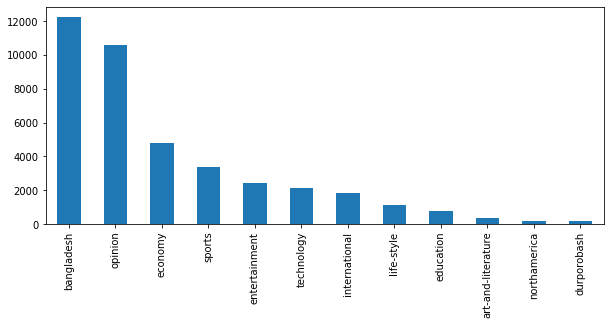

In [104]:
plt.figure(figsize=(10,4))
data.Label.value_counts().plot(kind='bar');

In [105]:
tags = data.Label.unique()
tags

array(['opinion', 'economy', 'bangladesh', 'sports', 'entertainment',
       'life-style', 'international', 'art-and-literature',
       'northamerica', 'technology', 'education', 'durporobash'],
      dtype=object)

In [106]:
p = ["!", "@",'–', "#", "|", "%", "(", ")", "।", "—", ".", "-", "", ",", "’", "•", "‘", ":", "*", "?",
          "০", "১", "২", "৩", "৪", "৫", "৬", "৭", "৮", "৯"]
for i in range(len(p)):
    data['Text'] = data['Text'].str.replace(p[i],'')

In [107]:
data['Text'].apply(lambda x: len(x.split(' '))).sum()

17153219

In [108]:
data['split'] = np.random.randn(data.shape[0], 1)
msk = np.random.rand(len(data)) <= 0.25
d1 = data[msk]
d2 = data[~msk]

In [109]:
# fraction of rows
# here you get 75% of the rows
train = d1.sample(frac=0.75, random_state=99)
test = d1.loc[~d1.index.isin(train.index), :]

In [112]:
train_size = train.shape[0]
test_size  = test.shape[0]

In [113]:
train_size, test_size

(7415, 2472)

In [114]:
# Extracting features from text files
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train['Text'].values.astype('U'))
X_train_counts.shape

(7415, 11726)

In [115]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(7415, 11726)

In [121]:
# Machine Learning
# Training Naive Bayes (NB) classifier on training data.
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, train.Label)

In [122]:
# Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
# The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
# We will be using the 'text_clf' going forward.
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

text_clf = text_clf.fit(train['Text'].values.astype('U'), train.Label)

In [123]:
# Performance of NB Classifier
predicted = text_clf.predict(test['Text'].values.astype('U'))
np.mean(predicted == test.Label)

0.5432847896440129

In [124]:
%%time
from sklearn.metrics import classification_report

print('accuracy %s' % accuracy_score(predicted, test.Label))
print(classification_report(test.Label, predicted,target_names=tags))

accuracy 0.5432847896440129
                    precision    recall  f1-score   support

           opinion       0.00      0.00      0.00        23
           economy       0.63      0.86      0.73       724
        bangladesh       0.00      0.00      0.00        11
            sports       1.00      0.17      0.28       302
     entertainment       0.00      0.00      0.00        42
        life-style       1.00      0.01      0.02       164
     international       0.00      0.00      0.00       125
art-and-literature       0.00      0.00      0.00        66
      northamerica       0.00      0.00      0.00        10
        technology       0.45      0.94      0.61       662
         education       1.00      0.19      0.32       218
       durporobash       1.00      0.04      0.08       125

          accuracy                           0.54      2472
         macro avg       0.42      0.18      0.17      2472
      weighted avg       0.63      0.54      0.44      2472

Wall time

C:\Users\Jenny\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [125]:
# Training Support Vector Machines - SVM and calculating its performance

from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=15, random_state=42))])

text_clf_svm = text_clf_svm.fit(train['Text'].values.astype('U'), train['Label'].values.astype('U'))
predicted_svm = text_clf_svm.predict(test['Text'].values.astype('U'))
np.mean(predicted_svm == test['Label'].values.astype('U'))

0.7900485436893204

In [126]:
%%time
print('accuracy %s' % accuracy_score(predicted_svm, test.Label))
print(classification_report(test.Label, predicted_svm,target_names=tags))

accuracy 0.7900485436893204
                    precision    recall  f1-score   support

           opinion       1.00      0.04      0.08        23
           economy       0.77      0.88      0.82       724
        bangladesh       0.00      0.00      0.00        11
            sports       0.80      0.79      0.80       302
     entertainment       1.00      0.12      0.21        42
        life-style       0.88      0.76      0.82       164
     international       1.00      0.06      0.12       125
art-and-literature       0.91      0.45      0.61        66
      northamerica       0.00      0.00      0.00        10
        technology       0.74      0.92      0.82       662
         education       0.89      0.95      0.92       218
       durporobash       0.84      0.75      0.79       125

          accuracy                           0.79      2472
         macro avg       0.74      0.48      0.50      2472
      weighted avg       0.80      0.79      0.76      2472

Wall time

In [129]:
# Grid Search
# Here, we are creating a list of parameters for which we would like to do performance tuning. 
# All the parameters name start with the classifier name (remember the arbitrary name we gave). 
# E.g. vect__ngram_range; here we are telling to use unigram and bigrams and choose the one which is optimal.

from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3)}

In [130]:
# Next, we create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(train['Text'].values.astype('U'), train['Label'].values.astype('U'))

In [131]:

# To see the best mean score and the params, run the following code

gs_clf.best_score_
gs_clf.best_params_


{'clf__alpha': 0.001, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}

In [134]:
predicted = gs_clf.predict(test['Text'].values.astype('U'))
np.mean(predicted == test.Label)

0.7961165048543689

In [135]:
%%time

print('accuracy %s' % accuracy_score(predicted, test.Label))
print(classification_report(test.Label, predicted,target_names=tags))

accuracy 0.7961165048543689
                    precision    recall  f1-score   support

           opinion       1.00      0.04      0.08        23
           economy       0.83      0.84      0.84       724
        bangladesh       0.00      0.00      0.00        11
            sports       0.89      0.78      0.83       302
     entertainment       0.80      0.38      0.52        42
        life-style       0.95      0.76      0.84       164
     international       0.94      0.23      0.37       125
art-and-literature       0.95      0.55      0.69        66
      northamerica       1.00      0.20      0.33        10
        technology       0.66      0.96      0.78       662
         education       0.98      0.89      0.93       218
       durporobash       0.89      0.70      0.78       125

          accuracy                           0.80      2472
         macro avg       0.82      0.53      0.58      2472
      weighted avg       0.82      0.80      0.78      2472

Wall time

C:\Users\Jenny\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [136]:

# Similarly doing grid search for SVM
from sklearn.model_selection import GridSearchCV
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False),'clf-svm__alpha': (1e-2, 1e-3)}

gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(train['Text'].values.astype('U'), train['Label'].values.astype('U'))


gs_clf_svm.best_score_
gs_clf_svm.best_params_

{'clf-svm__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}

In [137]:
predicted_svm = gs_clf_svm.predict(test['Text'].values.astype('U'))
np.mean(predicted_svm == test['Label'].values.astype('U'))

0.7900485436893204

In [138]:
%%time
from sklearn.metrics import classification_report

print('accuracy %s' % accuracy_score(predicted_svm, test.Label))
print(classification_report(test.Label, predicted_svm,target_names=tags))

accuracy 0.7900485436893204
                    precision    recall  f1-score   support

           opinion       1.00      0.04      0.08        23
           economy       0.77      0.88      0.82       724
        bangladesh       0.00      0.00      0.00        11
            sports       0.80      0.79      0.80       302
     entertainment       1.00      0.12      0.21        42
        life-style       0.88      0.76      0.82       164
     international       1.00      0.06      0.12       125
art-and-literature       0.91      0.45      0.61        66
      northamerica       0.00      0.00      0.00        10
        technology       0.74      0.92      0.82       662
         education       0.89      0.95      0.92       218
       durporobash       0.84      0.75      0.79       125

          accuracy                           0.79      2472
         macro avg       0.74      0.48      0.50      2472
      weighted avg       0.80      0.79      0.76      2472

Wall time

C:\Users\Jenny\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [139]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
# Create Decision Tree classifer object
text_clf_dt = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-dt', DecisionTreeClassifier(criterion='gini',splitter='best',
                                                           max_depth=20))])

# Train Decision Tree Classifer
text_clf_dt = text_clf_dt.fit(train['Text'].values.astype('U'), train['Label'].values.astype('U'))

#Predict the response for test dataset
predicted_dt = text_clf_dt.predict(test['Text'].values.astype('U'))
np.mean(predicted_dt == test['Label'].values.astype('U'))

0.5865695792880259

In [140]:
%%time
from sklearn.metrics import classification_report

print('accuracy %s' % accuracy_score(predicted_dt, test.Label))
print(classification_report(test.Label, predicted_dt,target_names=tags))

accuracy 0.5865695792880259
                    precision    recall  f1-score   support

           opinion       0.07      0.04      0.05        23
           economy       0.62      0.72      0.66       724
        bangladesh       0.00      0.00      0.00        11
            sports       0.50      0.52      0.51       302
     entertainment       0.21      0.21      0.21        42
        life-style       0.59      0.50      0.54       164
     international       0.22      0.10      0.14       125
art-and-literature       0.43      0.44      0.44        66
      northamerica       0.08      0.10      0.09        10
        technology       0.67      0.70      0.68       662
         education       0.72      0.56      0.63       218
       durporobash       0.44      0.46      0.45       125

          accuracy                           0.59      2472
         macro avg       0.38      0.36      0.37      2472
      weighted avg       0.57      0.59      0.58      2472

Wall time

In [143]:
from sklearn.linear_model import LogisticRegression

text_clf_lr = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf-lr', LogisticRegression(n_jobs=1, C=1e5)),
               ])
text_clf_lr = text_clf_lr.fit(train['Text'].values.astype('U'), train['Label'].values.astype('U'))

#Predict the response for test dataset
predicted_lr = text_clf_lr.predict(test['Text'].values.astype('U'))
np.mean(predicted_lr == test['Label'].values.astype('U'))

0.8211974110032363

In [144]:
%%time
from sklearn.metrics import classification_report

print('accuracy %s' % accuracy_score(predicted_lr, test.Label))
print(classification_report(test.Label, predicted_lr,target_names=tags))

accuracy 0.8211974110032363
                    precision    recall  f1-score   support

           opinion       0.70      0.30      0.42        23
           economy       0.83      0.84      0.84       724
        bangladesh       0.50      0.18      0.27        11
            sports       0.77      0.78      0.78       302
     entertainment       0.65      0.57      0.61        42
        life-style       0.88      0.82      0.85       164
     international       0.72      0.50      0.59       125
art-and-literature       0.78      0.74      0.76        66
      northamerica       0.50      0.30      0.37        10
        technology       0.83      0.89      0.86       662
         education       0.94      0.94      0.94       218
       durporobash       0.78      0.82      0.80       125

          accuracy                           0.82      2472
         macro avg       0.74      0.64      0.67      2472
      weighted avg       0.82      0.82      0.82      2472

Wall time